In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from datasets import input_processing

In [4]:
import cv2
img_path = 'data/jasper/jasper_ridge_224.mat'
gt_path = 'data/jasper/jasper_ridge_gt.mat'
start_band = 380; end_band = 2500
rgb_width = 64; rgb_height = 64
hsi_width = 32; hsi_height = 32
img_sri, img_rgb, gt = input_processing(img_path, gt_path, start_band, end_band)
img_hsi = img_sri#cv2.pyrDown(img_sri, dstsize=(50, 50))

In [5]:
print(img_hsi.shape, img_rgb.shape, gt.shape)

(100, 100, 224) (100, 100, 3) (100, 100, 4)


In [7]:
import numpy as np

In [ ]:
plt.imshow(img_hsi[:, :, 20], cmap="gray")
plt.show()

In [ ]:
plt.imshow(img_rgb)
plt.show()

In [8]:
gt = np.clip(gt, 0, 1).astype(float)

In [ ]:
plt.imshow(gt)

In [9]:
img_hsi_reshaped = img_hsi.reshape(-1, img_sri.shape[-1])
gt_reshaped = gt.reshape(-1, gt.shape[-1])
print(img_hsi_reshaped.shape, gt_reshaped.shape)

(10000, 224) (10000, 4)


(10000,)
Class 0
(753,)
Class 1
(2428,)
Class 2
(3326,)
Class 3
(3493,)


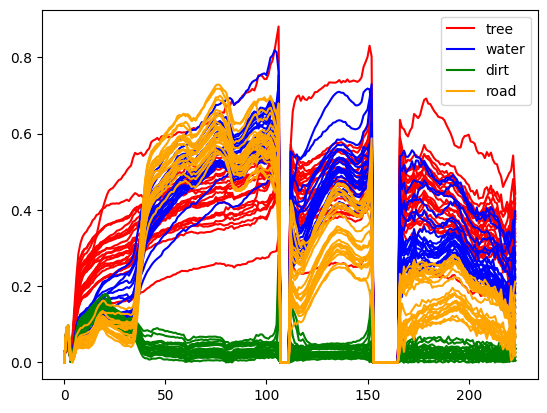

In [10]:
color = 3
colors = ['red', 'blue', 'green', 'orange']
label_names = ['tree', 'water', 'dirt', 'road']
num_classes = 4
indices = None
all_labels = np.argmax(gt_reshaped, axis=1)
print(all_labels.shape)
for c in range(num_classes):
    print('Class', c)
    indices_in_class = np.where(all_labels == c)[0]
    print(indices_in_class.shape)
    current_choices = np.random.choice(indices_in_class, size=25)
    if indices is None:
        indices = current_choices
    else:
        indices = np.append(indices, current_choices)
num_series = indices.shape[0]
num_pixels = img_hsi_reshaped.shape[0]
num_channels = img_hsi_reshaped.shape[1]
x =  np.arange(start=0, stop=num_channels, step=1)
cnt = 0
plotted = [False]*4
for i in indices:
    color_index = all_labels[i]
    if not plotted[color_index]:
        plotted[color_index] = True
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index], label=label_names[color_index])
    else:
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index])
plt.legend()

In [11]:
from motion_code.motion_code import MotionCode
from motion_code.data_processing import load_data, process_data_for_motion_codes

Y_train = img_hsi_reshaped[indices, :].reshape(num_series, 1, -1)
labels_train = np.argmax(gt_reshaped[indices, :], axis=1)
print(Y_train.shape, labels_train.shape)

# Then we process the data for motion code model and generate X-variable, which is needed for training.
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)
print(X_train.shape, Y_train.shape, labels_train.shape)

# Next we build the default motion code model for both forecasting and classification
model = MotionCode(m=8, Q=1, latent_dim=2, sigma_y=0.1)

# Then we train model on the given X_train, Y_train, label_train set and saved it to a file named test_model.
model_path = 'motion_code/saved_models/' + 'test_model'
model.fit(X_train, Y_train, labels_train, model_path)

(100, 1, 224) (100,)
(100, 224) (100, 224) (100,)


In [12]:
model_path = 'motion_code/saved_models/test_model'
model.load(model_path)

In [22]:
from motion_code.sparse_gp import sigmoid
num_motion = np.unique(labels_train).shape[0]
X_m, Z = model.X_m, model.Z
revised_hsi = np.zeros((img_hsi_reshaped.shape[0], 8))
print(revised_hsi.shape)
for k in range(num_motion):
    most_informative_indices = np.rint(num_channels * sigmoid(X_m @ Z[k])).astype(int)
    print('Class', k, ':', most_informative_indices)
    revised_hsi[all_labels==k, :] = img_hsi_reshaped[all_labels==k][:,most_informative_indices]


(10000, 8)
Class 0 : [  7  34  69 105 140 175 201 223]
Class 1 : [  9  38  72 106 138 171 197 223]
Class 2 : [  6  32  67 105 141 177 202 223]
Class 3 : [  9  38  72 106 138 171 197 223]


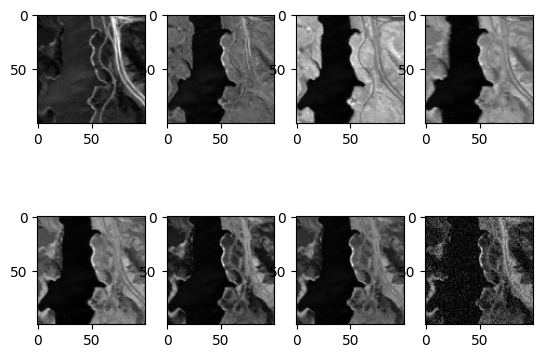

In [27]:
f, axarr = plt.subplots(2,4)
for r in range(2):
    for c in range(4):
        i = r*4 + c
        axarr[r, c].imshow(revised_hsi[:, i].reshape(100, 100), cmap='gray')

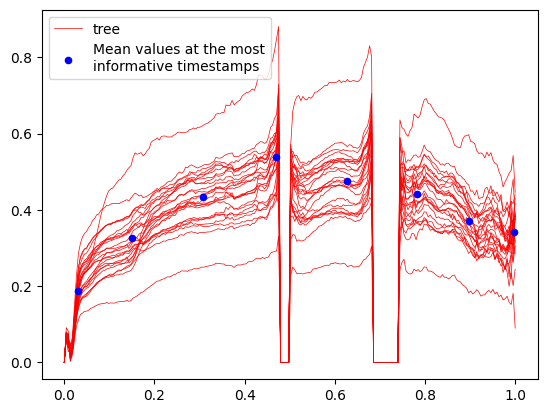

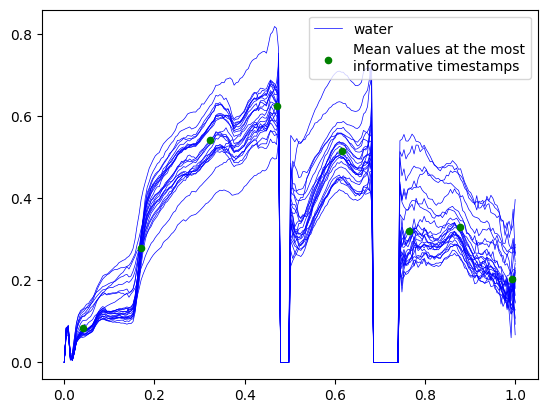

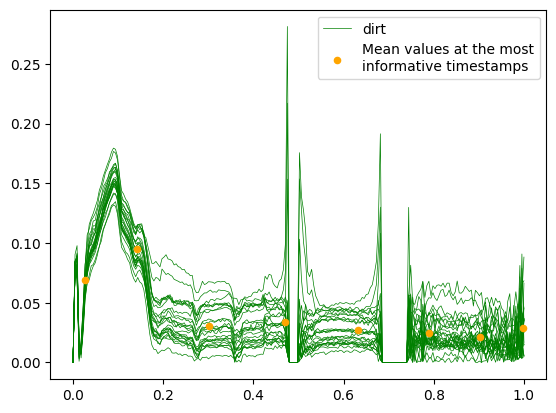

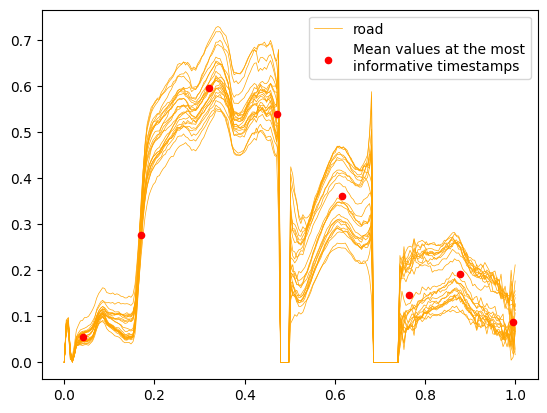

<Figure size 640x480 with 0 Axes>

In [28]:
from motion_code.utils import plot_motion_codes
plot_motion_codes(X_train, Y_train, test_time_horizon=None, labels=labels_train, label_names=label_names,
                           model=model, output_dir='motion_code/out/multiple/', additional_data=None)